In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from matplotlib import pyplot as plt
from keras.datasets import fashion_mnist as fmnist
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, LeakyReLU, BatchNormalization, Dropout


<h3>Loading the train test splits for fashion_mnist</h3>

In [ ]:
(train_X, train_y), (test_X, test_y) = fmnist.load_data()
print(np.shape(train_X))

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)


<h3>Preprocessing data</h3>

In [ ]:
def normalize(image):
    
    image = tf.cast(image, dtype=float)/255

    return image

def one_hot_matrix(labels, depth = 10):
    
    one_hot = tf.reshape(tf.one_hot(labels, depth, axis = 0), [-1,])
    
    return one_hot

train_X = tf.data.Dataset.from_tensor_slices(train_X)
train_y = tf.data.Dataset.from_tensor_slices(train_y)

test_X = tf.data.Dataset.from_tensor_slices(test_X)
test_y = tf.data.Dataset.from_tensor_slices(test_y)

new_train_X = train_X.map(normalize)
new_test_X = test_X.map(normalize)

new_train_y = train_y.map(one_hot_matrix)
new_test_y = test_y.map(one_hot_matrix)

train_datset = tf.data.Dataset.zip((new_train_X, new_train_y)).batch(32).prefetch(6)
test_datset = tf.data.Dataset.zip((new_test_X, new_test_y)).batch(32).prefetch(6)


<h3>Conv Block</h3>

In [ ]:
def ConvBlock(prev, filter_size, num_filters, drop = True, padding = 'valid', pool = True):

  X = Conv2D(num_filters, kernel_size = (filter_size,filter_size), strides = (1,1), use_bias = True, padding = padding, kernel_initializer = 'glorot_normal')(prev)

  X = LeakyReLU()(X)

  X = BatchNormalization(axis = 3, trainable = True)(X)

  if pool == True:
    X = MaxPool2D(pool_size= (2,2), strides = (2,2))(X)

  if drop == True:
    X = Dropout(0.1)(X)

  return X

<h3>Defining the Model</h3>

In [ ]:
def Classifier_model(input_shape):

  input_img = tf.keras.Input(shape = input_shape)

  CBlock1 = ConvBlock(input_img, filter_size=4, num_filters=256, padding='same')

  CBlock2 = ConvBlock(CBlock1, filter_size=4, num_filters=128, pool=False)

  CBlock3 = ConvBlock(CBlock2, filter_size=2, num_filters=128, padding='same')

  CBlock4 = ConvBlock(CBlock3, filter_size=2, num_filters=64)

  Flat = Flatten()(CBlock4)

  outputs = Dense(units = 10, activation = 'softmax')(Flat)

  model = tf.keras.Model(inputs = input_img, outputs = outputs)   

  return model


<h3>Creating the Model Object</h3>

In [ ]:
Model = Classifier_model((28,28,1))
Model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
Model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 256)       4352      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 28, 28, 256)       0         
                                                                 
 batch_normalization_4 (Batc  (None, 28, 28, 256)      1024      
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 256)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 256)       0   

<h3>Training the Model</h3>

In [ ]:
device_name = tf.test.gpu_device_name()
print(device_name)

with tf.device('/device:GPU:0'):
    history = Model.fit(train_datset, epochs = 40, validation_data = test_datset)


/device:GPU:0
Epoch 1/40
1875/1875 [==============================] - 23s 12ms/step - loss: 0.4464 - accuracy: 0.8405 - val_loss: 0.4279 - val_accuracy: 0.8478
Epoch 2/40
1875/1875 [==============================] - 22s 12ms/step - loss: 0.3206 - accuracy: 0.8842 - val_loss: 0.3162 - val_accuracy: 0.8889
Epoch 3/40
1875/1875 [==============================] - 22s 12ms/step - loss: 0.2841 - accuracy: 0.8972 - val_loss: 0.3353 - val_accuracy: 0.8821
Epoch 4/40
1875/1875 [==============================] - 22s 12ms/step - loss: 0.2613 - accuracy: 0.9057 - val_loss: 0.2984 - val_accuracy: 0.8963
Epoch 5/40
1875/1875 [==============================] - 22s 12ms/step - loss: 0.2447 - accuracy: 0.9108 - val_loss: 0.2827 - val_accuracy: 0.9041
Epoch 6/40
1875/1875 [==============================] - 22s 12ms/step - loss: 0.2270 - accuracy: 0.9166 - val_loss: 0.3070 - val_accuracy: 0.8927
Epoch 7/40
1875/1875 [==============================] - 22s 12ms/step - loss: 0.2141 - accuracy: 0.9222 - val_

<h3>Visualizing Model Loss and Model Accuracy over training</h3>

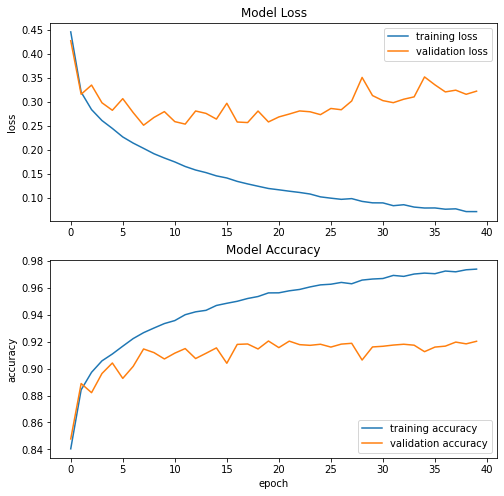

In [ ]:
# import pandas as pd

# history = pd.DataFrame(history.history)

# history.rename(columns = {'loss':'training loss', 'val_loss':'validation loss', 'accuracy':'training accuracy', 'val_accuracy': 'validation accuracy'}, inplace=True)

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(history['training loss'], label = 'training loss')
plt.plot(history['validation loss'], label = 'validation loss')
plt.title('Model Loss')
plt.ylabel('loss')
plt.legend(loc = 'upper right')

plt.subplot(2,1,2)
plt.plot(history['training accuracy'], label = 'training accuracy')
plt.plot(history['validation accuracy'], label = 'validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(loc = 'lower right')


<h3>Saving the Model</h3>

In [ ]:
Model.save('Model')

INFO:tensorflow:Assets written to: Model/assets


In [ ]:
!zip -r /content/Model.zip /content/Model

  adding: content/Model/ (stored 0%)
  adding: content/Model/saved_model.pb (deflated 90%)
  adding: content/Model/keras_metadata.pb (deflated 93%)
  adding: content/Model/assets/ (stored 0%)
  adding: content/Model/variables/ (stored 0%)
  adding: content/Model/variables/variables.data-00000-of-00001 (deflated 5%)
  adding: content/Model/variables/variables.index (deflated 72%)


<h3>Notes for the first v2.2 of the Model</h3>

The CNN does reasonably well now. Unlike the very first model, there are no exploding/vanishing gradients and hence no freaky accuracy values. The occurence of such abnormal values was tried to be reduced by dropout, normal initialization, batch normalization and l2 or l1 initialization. The CNN model was also changed and more Conv blocks were added to fit the dataset better with more tunable parameters. At the end, only a dropout of 0.1, batch normalization, and normal initialization were used to reduce the variance. The Model is now ~92% accurate on the test set and ~97% accurate on the training set.